# Real Estate Analysis: Rent vs. Sale (Poland)

## 1. Introduction & Data Loading
In this notebook, we will perform a comprehensive Exploratory Data Analysis (EDA) on two datasets regarding real estate in Poland: one for rental offers and one for sale offers.

Our goals are to:
1.  **Clean and Prepare** the data.
2.  **Explore** distributions of prices, sizes, and locations.
3.  **Analyze** the relationships between key features (e.g., floor level, building year) and price.
4.  **Compare** the rental and sales markets.
5.  **Build Machine Learning models** to predict property prices.

Let's start by importing the necessary libraries and loading the datasets.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load the datasets
# Assuming files are in the same directory. Adjust path if necessary.
try:
    df_rent = pd.read_csv('/Users/aliyusifov/Desktop/housing_price_poland/data/processed/rent_structured.csv')
    df_sale = pd.read_csv('/Users/aliyusifov/Desktop/housing_price_poland/data/processed/sale_structured.csv')
    print("Datasets loaded successfully.")
except FileNotFoundError:
    print("Error: Files not found. Please check file paths.")

# Display basic info to check for nulls and data types
print("--- RENT DATA INFO ---")
df_rent.info()
print("\n" + "="*50 + "\n")

print("--- SALE DATA INFO ---")
df_sale.info()

# Display first few rows to verify structure
display(df_rent.head(3))
display(df_sale.head(3))

Datasets loaded successfully.
--- RENT DATA INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70847 entries, 0 to 70846
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    70847 non-null  object 
 1   city                  70847 non-null  object 
 2   type                  54085 non-null  object 
 3   squareMeters          70847 non-null  float64
 4   rooms                 70847 non-null  float64
 5   floor                 62234 non-null  float64
 6   floorCount            69468 non-null  float64
 7   buildYear             51165 non-null  float64
 8   latitude              70847 non-null  float64
 9   longitude             70847 non-null  float64
 10  centreDistance        70847 non-null  float64
 11  poiCount              70847 non-null  float64
 12  schoolDistance        70832 non-null  float64
 13  clinicDistance        70797 non-null  float64
 14  postOfficeDistanc

,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,...,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,report_date
0,727a1427f156535fc0531e59a27e7988,szczecin,blockOfFlats,34.0,1.0,2.0,3.0,NaN,53.394002,14.523988,...,condominium,NaN,premium,0,1,0,0,1,1700,2024-06-01
1,a640ac5f62cce4d6806a7b7d73b5cd52,szczecin,apartmentBuilding,39.0,2.0,5.0,7.0,2022.0,53.404646,14.492033,...,condominium,brick,premium,1,1,1,0,0,3400,2024-06-01
2,40cb3c6185236a3e4f136641ab7099a4,szczecin,apartmentBuilding,47.0,2.0,4.0,12.0,2016.0,53.438231,14.562027,...,condominium,brick,premium,1,1,1,1,1,2700,2024-06-01


,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,...,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price,report_date
0,a01d82c9529f98a54d64b9e061c9a73b,szczecin,apartmentBuilding,105.00,4.0,3.0,4.0,2016.0,53.431503,14.485820,...,condominium,brick,premium,0,1,1,0,0,1199999,2023-12-01
1,d68ea84e5d35da9e282150332bdc22f3,szczecin,blockOfFlats,94.40,4.0,4.0,5.0,NaN,53.441253,14.511030,...,condominium,brick,premium,1,1,0,0,1,1150000,2023-12-01
2,420295cc23d693fdffd5ccc9ba35ba98,szczecin,NaN,48.29,2.0,8.0,11.0,2014.0,53.399444,14.526111,...,condominium,NaN,unknown,1,1,1,0,1,625000,2023-12-01


## 2. Data Cleaning & Preprocessing
We observed missing values in `type`, `buildYear`, and `buildingMaterial`. We also need to convert dates and filter out any logical errors (like 0 sqm apartments).

**Steps taken:**
1. Convert `report_date` to datetime.
2. Fill missing categorical values with 'unknown'.
3. Remove duplicates.
4. Filter out unrealistic data (Price <= 0, Area <= 0).

In [4]:
# 1. Convert report_date to datetime
df_rent['report_date'] = pd.to_datetime(df_rent['report_date'])
df_sale['report_date'] = pd.to_datetime(df_sale['report_date'])

# 2. Handle Categorical Missing Values
# We fill these with 'unknown' to retain the data rows
cat_cols_to_fill = ['type', 'buildingMaterial', 'condition']

for col in cat_cols_to_fill:
    df_rent[col] = df_rent[col].fillna('unknown')
    df_sale[col] = df_sale[col].fillna('unknown')

# 3. Remove Duplicates
init_len_rent = len(df_rent)
init_len_sale = len(df_sale)
df_rent.drop_duplicates(inplace=True)
df_sale.drop_duplicates(inplace=True)

print(f"Duplicates removed: Rent: {init_len_rent - len(df_rent)}, Sale: {init_len_sale - len(df_sale)}")

# 4. Basic Sanity Checks (Filter out unrealistic values)
# Square meters must be > 0, Price must be > 0
df_rent = df_rent[(df_rent['squareMeters'] > 0) & (df_rent['price'] > 0)]
df_sale = df_sale[(df_sale['squareMeters'] > 0) & (df_sale['price'] > 0)]

# Check logical consistency: floor shouldn't be higher than floorCount
# (We only check rows where both are not null)
mask_rent = (df_rent['floor'] > df_rent['floorCount'])
mask_sale = (df_sale['floor'] > df_sale['floorCount'])

# Let's count how many errors like this exist
print(f"Rent entries with floor > floorCount: {mask_rent.sum()}")
print(f"Sale entries with floor > floorCount: {mask_sale.sum()}")

# 5. Statistical Summary of Cleaned Data
print("\n--- RENT STATS (Numerical) ---")
display(df_rent[['price', 'squareMeters', 'buildYear', 'floor']].describe().round(2))

print("\n--- SALE STATS (Numerical) ---")
display(df_sale[['price', 'squareMeters', 'buildYear', 'floor']].describe().round(2))

Duplicates removed: Rent: 0, Sale: 0
Rent entries with floor > floorCount: 0
Sale entries with floor > floorCount: 0

--- RENT STATS (Numerical) ---


,price,squareMeters,buildYear,floor
count,70847.00,70847.00,51165.00,62234.00
mean,3852.80,55.25,1998.11,3.42
std,2381.54,22.69,30.29,2.65
min,346.00,25.00,1850.00,1.00
25%,2500.00,40.00,1984.00,2.00
50%,3100.00,50.00,2010.00,3.00
75%,4490.00,64.00,2020.00,4.00
max,23000.00,150.00,2024.00,30.00



--- SALE STATS (Numerical) ---


,price,squareMeters,buildYear,floor
count,195568.00,195568.00,163352.00,160974.00
mean,784183.30,58.70,1985.98,3.33
std,409709.23,21.41,33.81,2.53
min,150000.00,25.00,1850.00,1.00
25%,520000.00,44.00,1967.00,2.00
50%,699000.00,54.60,1994.00,3.00
75%,930000.00,68.55,2016.00,4.00
max,3250000.00,150.00,2024.00,29.00


## 3. Simple EDA: Univariate Distributions
We will now examine the distributions of Prices and Apartment Sizes for both Rent and Sale datasets.

**Key Questions:**
* Are prices normally distributed or skewed?
* What is the typical size of an apartment?
* How do prices vary across different cities?

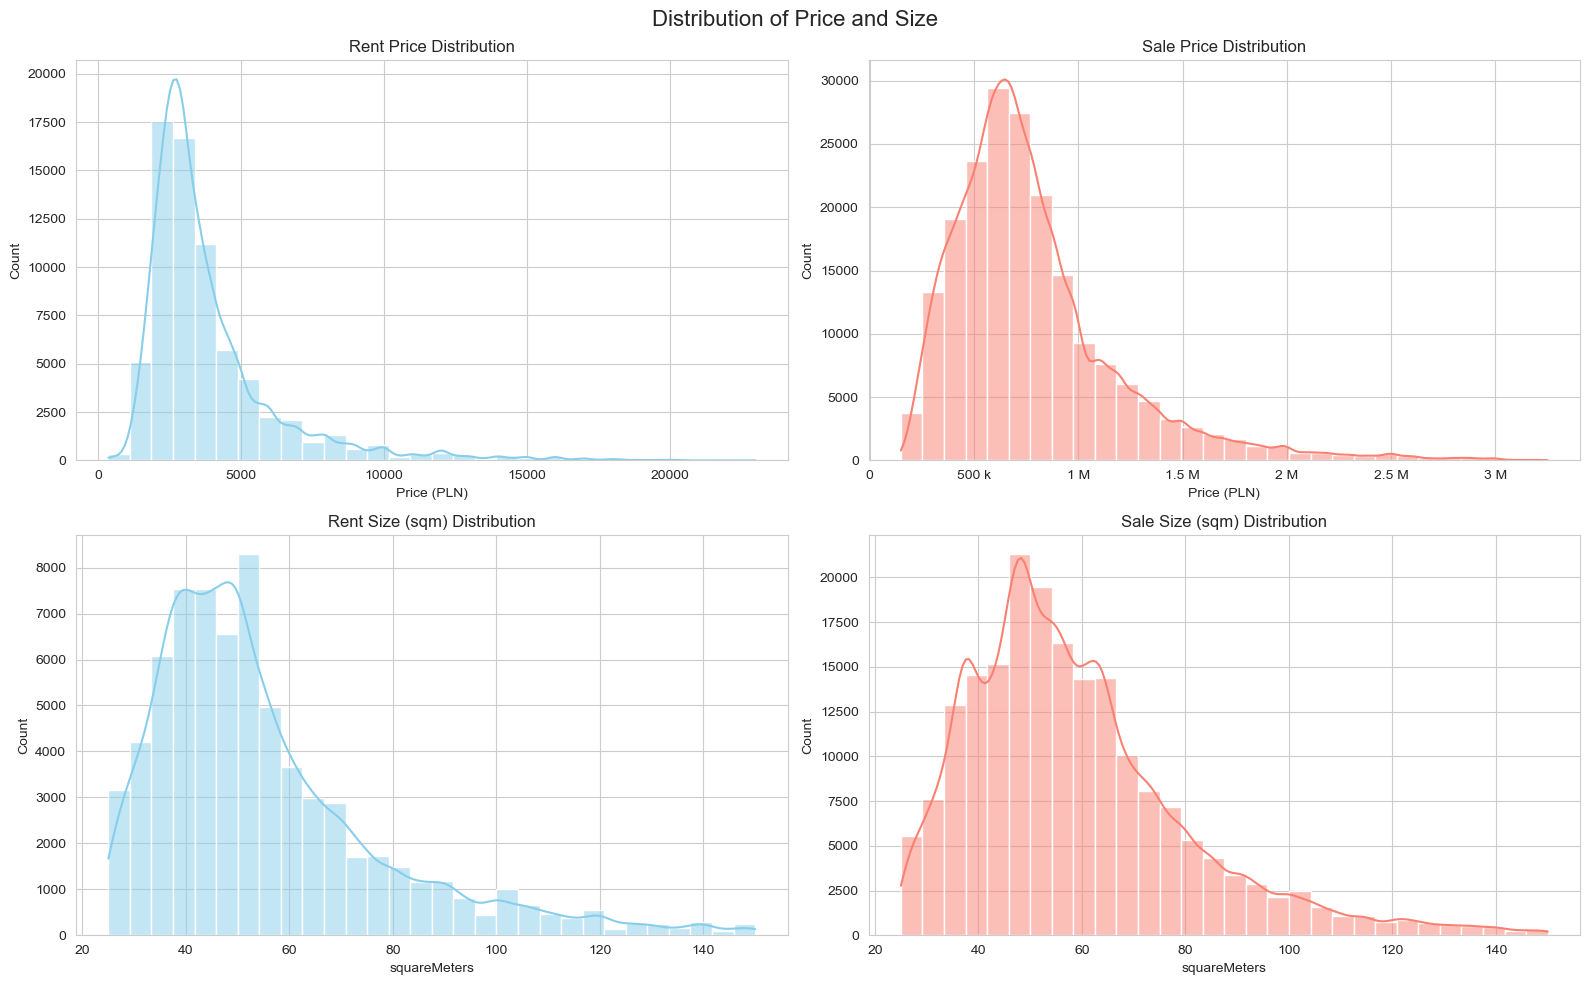

/var/folders/kd/x925vvpn0gl9vp8rd0sbvsxr0000gn/T/ipykernel_62097/3815879406.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_rent[df_rent['city'].isin(top_cities)], x='city', y='price', ax=axes[0], palette='Blues', order=top_cities)
/var/folders/kd/x925vvpn0gl9vp8rd0sbvsxr0000gn/T/ipykernel_62097/3815879406.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sale[df_sale['city'].isin(top_cities)], x='city', y='price', ax=axes[1], palette='Reds', order=top_cities)


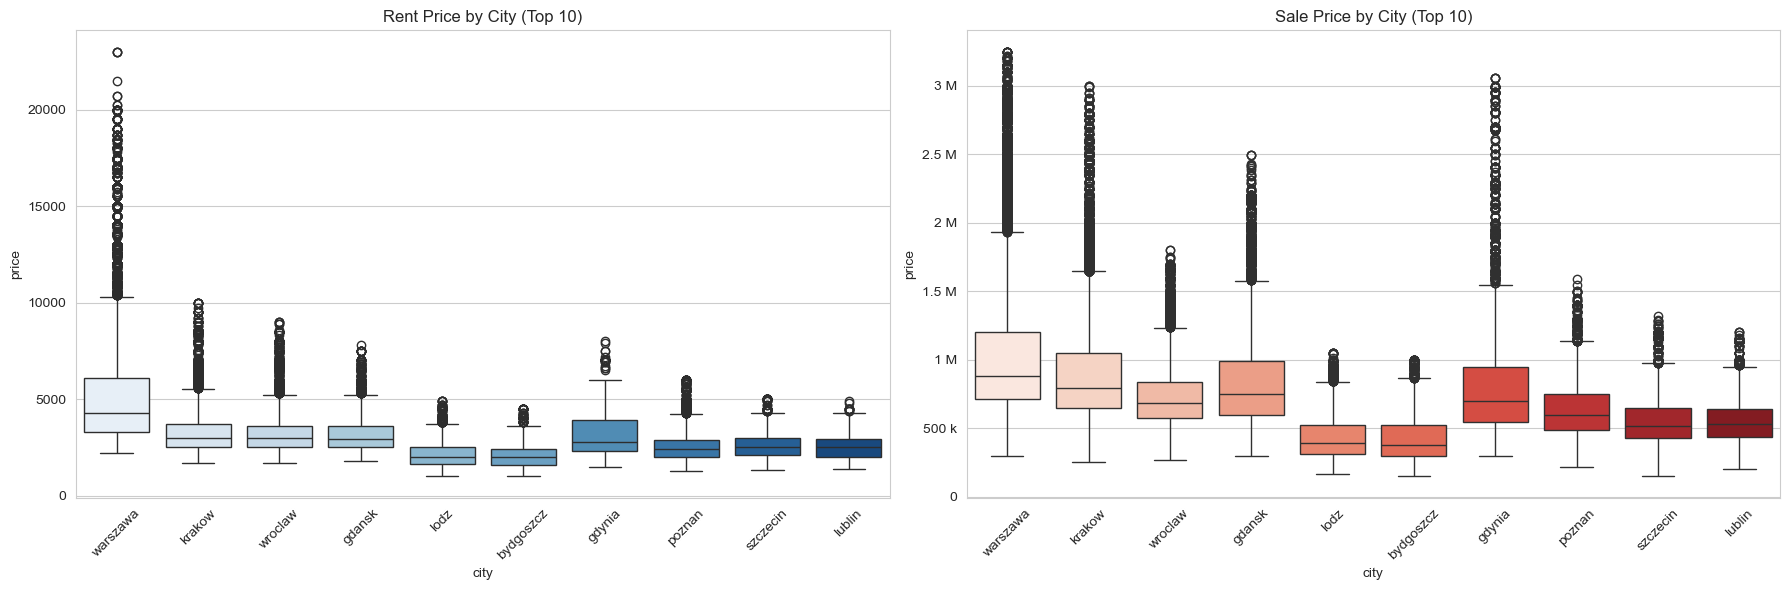

In [5]:
import matplotlib.ticker as ticker

# 1. Distribution Plots (Histograms)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Distribution of Price and Size', fontsize=16)

# Rent Price
sns.histplot(df_rent['price'], kde=True, ax=axes[0, 0], color='skyblue', bins=30)
axes[0, 0].set_title('Rent Price Distribution')
axes[0, 0].set_xlabel('Price (PLN)')

# Sale Price
sns.histplot(df_sale['price'], kde=True, ax=axes[0, 1], color='salmon', bins=30)
axes[0, 1].set_title('Sale Price Distribution')
axes[0, 1].set_xlabel('Price (PLN)')
# Format x-axis for Sale Price to usually show millions/thousands nicely
axes[0, 1].xaxis.set_major_formatter(ticker.EngFormatter())

# Rent Size
sns.histplot(df_rent['squareMeters'], kde=True, ax=axes[1, 0], color='skyblue', bins=30)
axes[1, 0].set_title('Rent Size (sqm) Distribution')

# Sale Size
sns.histplot(df_sale['squareMeters'], kde=True, ax=axes[1, 1], color='salmon', bins=30)
axes[1, 1].set_title('Sale Size (sqm) Distribution')

plt.tight_layout()
plt.show()

# 2. Boxplots: Price vs City (Top 10 Cities by count)
# We find the top 10 cities by number of listings to keep the chart readable
top_cities = df_sale['city'].value_counts().head(10).index

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Rent Boxplot
sns.boxplot(data=df_rent[df_rent['city'].isin(top_cities)], x='city', y='price', ax=axes[0], palette='Blues', order=top_cities)
axes[0].set_title('Rent Price by City (Top 10)')
axes[0].tick_params(axis='x', rotation=45)

# Sale Boxplot
sns.boxplot(data=df_sale[df_sale['city'].isin(top_cities)], x='city', y='price', ax=axes[1], palette='Reds', order=top_cities)
axes[1].set_title('Sale Price by City (Top 10)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].yaxis.set_major_formatter(ticker.EngFormatter())

plt.tight_layout()
plt.show()

## 4. Advanced EDA: Relationships & Correlations
Now we investigate how different variables interact with Price.

**Key Questions:**
* Which numerical features correlate most strongly with Price?
* Is the relationship between Size and Price linear?
* How strongly does distance from the city centre affect the value?

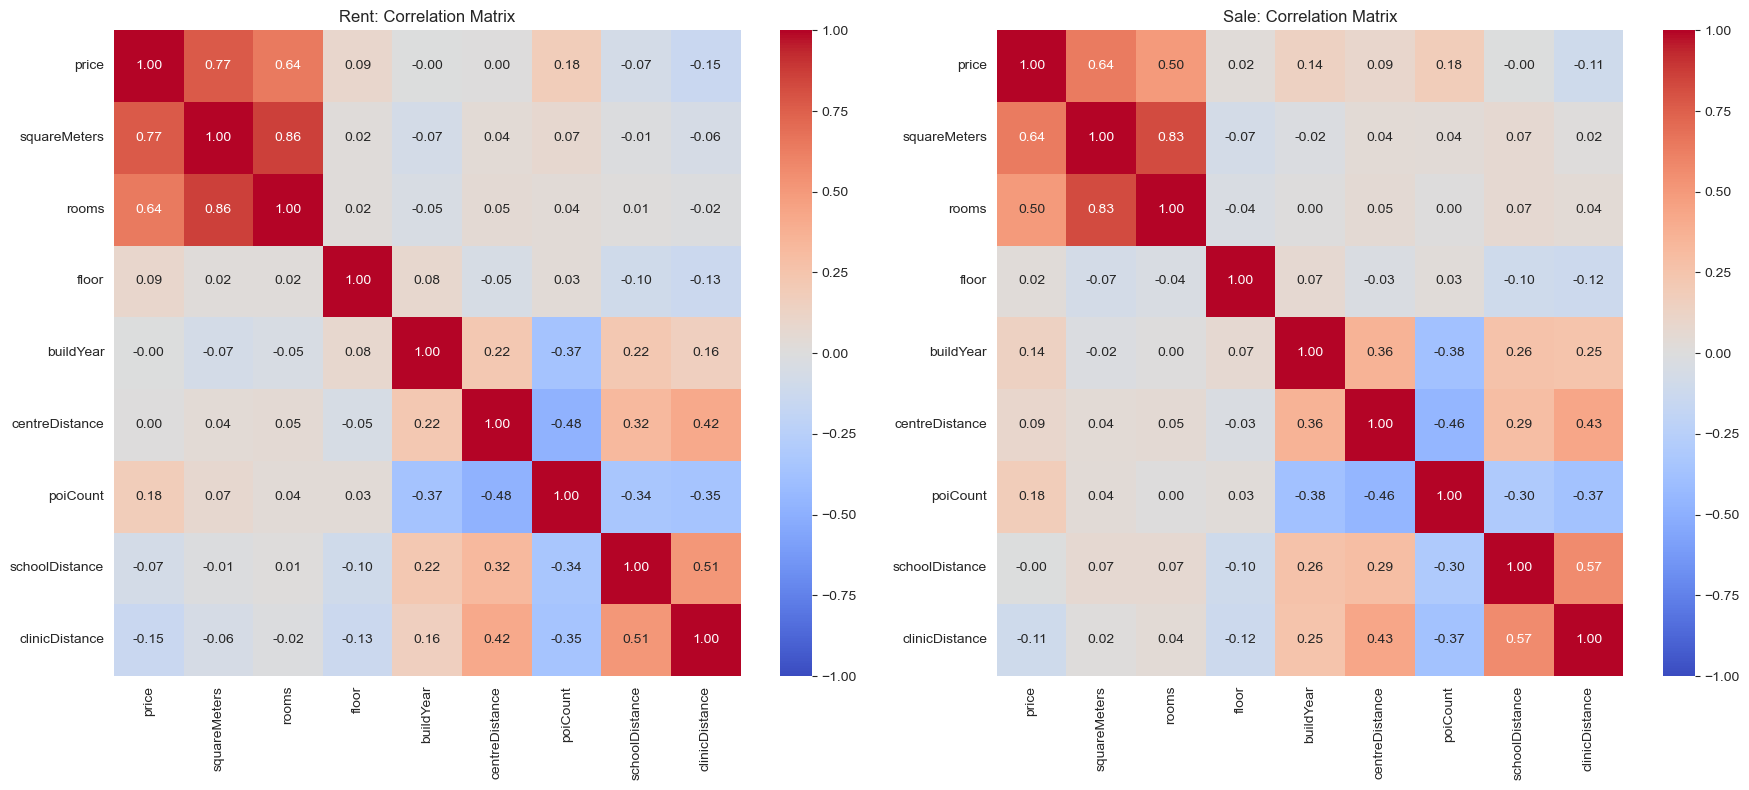

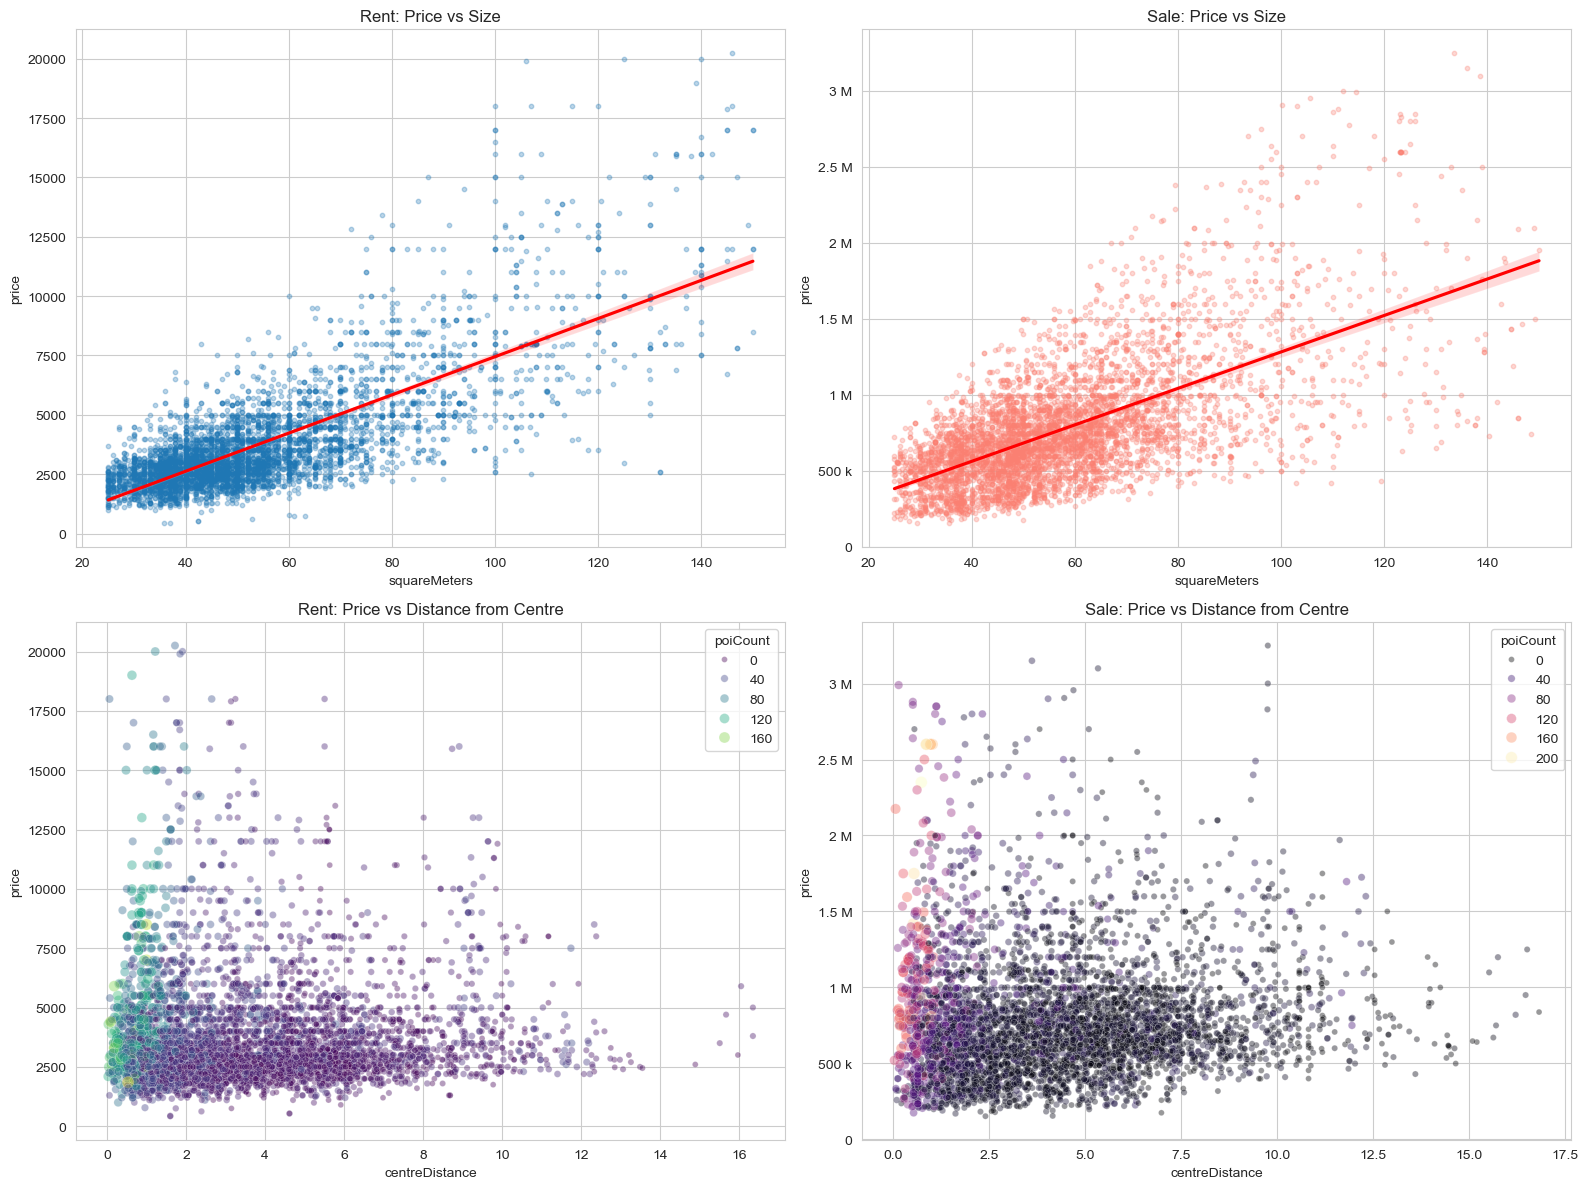

In [6]:
# Select numeric columns for correlation analysis
# We exclude 'id', 'lat', 'lon' as they don't have linear meaning in this context
numeric_cols = ['price', 'squareMeters', 'rooms', 'floor', 'buildYear', 
                'centreDistance', 'poiCount', 'schoolDistance', 'clinicDistance']

# Calculate correlation matrices
corr_rent = df_rent[numeric_cols].corr()
corr_sale = df_sale[numeric_cols].corr()

# 1. Correlation Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.heatmap(corr_rent, annot=True, fmt=".2f", cmap='coolwarm', ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title('Rent: Correlation Matrix')

sns.heatmap(corr_sale, annot=True, fmt=".2f", cmap='coolwarm', ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title('Sale: Correlation Matrix')

plt.tight_layout()
plt.show()

# 2. Scatter Plots: Price Drivers (Using a sample for clarity)
# We sample 5000 points to avoid over-plotting
sample_rent = df_rent.sample(n=5000, random_state=42)
sample_sale = df_sale.sample(n=5000, random_state=42)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Row 1: Price vs Square Meters
sns.regplot(data=sample_rent, x='squareMeters', y='price', ax=axes[0, 0], 
            scatter_kws={'alpha':0.3, 's':10}, line_kws={'color':'red'})
axes[0, 0].set_title('Rent: Price vs Size')

sns.regplot(data=sample_sale, x='squareMeters', y='price', ax=axes[0, 1], 
            scatter_kws={'alpha':0.3, 's':10, 'color':'salmon'}, line_kws={'color':'red'})
axes[0, 1].set_title('Sale: Price vs Size')
axes[0, 1].yaxis.set_major_formatter(ticker.EngFormatter())

# Row 2: Price vs Centre Distance
sns.scatterplot(data=sample_rent, x='centreDistance', y='price', ax=axes[1, 0], 
                alpha=0.4, hue='poiCount', palette='viridis', size='poiCount')
axes[1, 0].set_title('Rent: Price vs Distance from Centre')

sns.scatterplot(data=sample_sale, x='centreDistance', y='price', ax=axes[1, 1], 
                alpha=0.4, hue='poiCount', palette='magma', size='poiCount')
axes[1, 1].set_title('Sale: Price vs Distance from Centre')
axes[1, 1].yaxis.set_major_formatter(ticker.EngFormatter())

plt.tight_layout()
plt.show()

## 5. Machine Learning Preparation (Sale Data)
We are preparing the **Sale** dataset for machine learning.

**Preprocessing Pipeline:**
1. **Imputation:** Fill missing `buildYear` and `floor` with the median.
2. **Encoding:** Convert categorical text variables (City, Type, Condition) into dummy variables (0/1).
3. **Log Transformation:** Transform the target `price` to `log(price)` to normalize the distribution.
4. **Splitting:** Split data into 80% Training and 20% Testing.

In [7]:
from sklearn.model_selection import train_test_split

# 1. Select Features and Target
# We drop 'id' (useless), 'report_date' (time leakage), and 'price' (target)
target_col = 'price'
drop_cols = ['id', 'report_date', 'price', 'latitude', 'longitude'] 
# Note: We drop lat/lon because we are using 'city' and 'distance'. 
# Keeping coordinates + city + distance can confuse simple models (collinearity).

# Create a copy to avoid SettingWithCopy warnings
df_ml = df_sale.copy()

# 2. Impute Missing Values (Numerical)
# We use median because it's robust to outliers
df_ml['floor'] = df_ml['floor'].fillna(df_ml['floor'].median())
df_ml['buildYear'] = df_ml['buildYear'].fillna(df_ml['buildYear'].median())

# 3. Log Transform the Target
# We predict log_price because the original price distribution is skewed
y = np.log1p(df_ml['price']) # log1p = log(x + 1) to avoid log(0) errors

# 4. Encode Categorical Variables (One-Hot Encoding)
# This turns 'city' column into 'city_warsaw', 'city_krakow', etc.
X = df_ml.drop(columns=drop_cols)
X = pd.get_dummies(X, drop_first=True)

print(f"Feature set shape after encoding: {X.shape}")

# 5. Train-Test Split
# 80% of data for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# Show the first few rows of the processed features
display(X_train.head(3))

Feature set shape after encoding: (195568, 42)
Training samples: 156454
Testing samples: 39114


,squareMeters,rooms,floor,floorCount,buildYear,centreDistance,poiCount,schoolDistance,clinicDistance,postOfficeDistance,...,city_wroclaw,type_blockOfFlats,type_tenement,type_unknown,ownership_cooperative,ownership_udział,buildingMaterial_concreteSlab,buildingMaterial_unknown,condition_premium,condition_unknown
51646,46.05,2.0,3.0,7.0,2015.0,3.88,27.0,0.282,0.485,0.220,...,False,True,False,False,False,False,False,False,False,True
13529,74.80,3.0,3.0,10.0,1993.0,7.03,16.0,0.332,0.452,0.152,...,False,True,False,False,True,False,True,False,False,False
161501,72.98,5.0,2.0,2.0,1992.0,4.52,9.0,0.450,0.131,0.457,...,False,False,False,True,False,False,False,True,False,True


## 6. Model Training & Evaluation
We will compare a **Linear Regression** baseline against a **Random Forest Regressor**.

**Metrics:**
* **R²:** Explains variance (1.0 is perfect).
* **RMSE:** Average error in PLN (Lower is better).

*Note: We use `n_jobs=-1` to use all CPU cores and speed up the Random Forest.*

Data successfully cleaned and split!
Any NaNs remaining? False

Training Linear Regression...
--- Linear Regression Performance ---
RMSE (Average Error): 197,702 PLN
R² Score: 0.7678
------------------------------
Training Random Forest... (this will take about 30-60 seconds)
--- Random Forest Performance ---
RMSE (Average Error): 80,203 PLN
R² Score: 0.9618
------------------------------


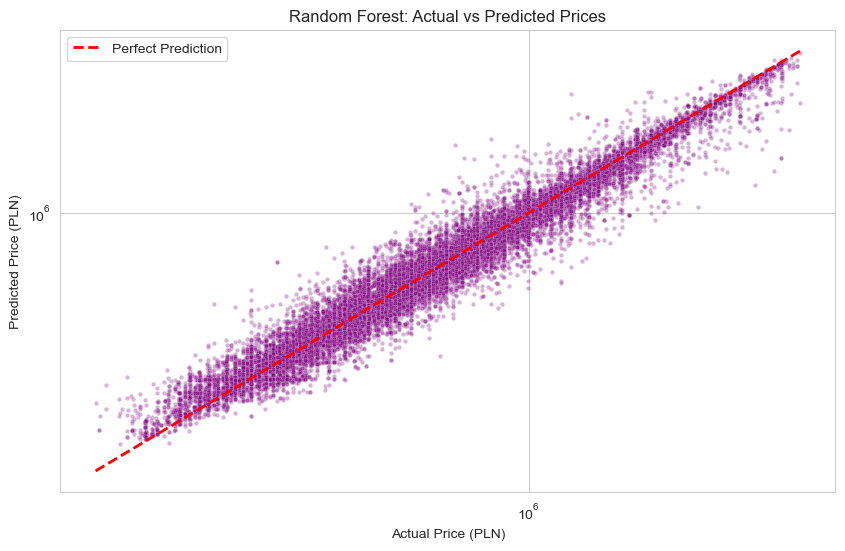

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- RE-PREPROCESSING ---

# 1. Create a fresh copy
df_ml = df_sale.copy()

# 2. Impute ALL missing numerical values
# We select all float/int columns and fill NaNs with their median
numeric_cols = df_ml.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    if df_ml[col].isnull().any():
        df_ml[col] = df_ml[col].fillna(df_ml[col].median())

# 3. Log Transform Target
y = np.log1p(df_ml['price'])

# 4. Drop unnecessary columns and Encode
drop_cols = ['id', 'report_date', 'price', 'latitude', 'longitude']
X = df_ml.drop(columns=drop_cols)
X = pd.get_dummies(X, drop_first=True)

# 5. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data successfully cleaned and split!")
print(f"Any NaNs remaining? {X_train.isnull().any().any()}") # Should be False now

# --- MODEL TRAINING ---

def evaluate_model(model, X_test, y_test, model_name):
    # Predict and convert back to PLN
    y_pred_log = model.predict(X_test)
    y_pred_pln = np.expm1(y_pred_log)
    y_test_pln = np.expm1(y_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_pln, y_pred_pln))
    r2 = r2_score(y_test_pln, y_pred_pln)
    
    print(f"--- {model_name} Performance ---")
    print(f"RMSE (Average Error): {rmse:,.0f} PLN")
    print(f"R² Score: {r2:.4f}")
    print("-" * 30)
    return y_test_pln, y_pred_pln

# 1. Linear Regression
print("\nTraining Linear Regression...")
lr = LinearRegression()
lr.fit(X_train, y_train)
y_true_lr, y_pred_lr = evaluate_model(lr, X_test, y_test, "Linear Regression")

# 2. Random Forest (Optimized for speed)
print("Training Random Forest... (this will take about 30-60 seconds)")
rf = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_true_rf, y_pred_rf = evaluate_model(rf, X_test, y_test, "Random Forest")

# --- PLOTTING ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true_rf, y=y_pred_rf, alpha=0.3, color='purple', s=10)
plt.plot([y_true_rf.min(), y_true_rf.max()], [y_true_rf.min(), y_true_rf.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price (PLN)')
plt.ylabel('Predicted Price (PLN)')
plt.title('Random Forest: Actual vs Predicted Prices')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

## 7. Feature Importance
Our Random Forest model performed exceptionally well ($R^2 = 0.96$). Now, we extract the "Feature Importances" to understand which factors drove the model's decisions the most.

Top 10 Most Important Features:


,Feature,Importance
0,squareMeters,0.398772
31,city_warszawa,0.163403
4,buildYear,0.095013
24,city_krakow,0.073329
5,centreDistance,0.043685
21,city_gdansk,0.042587
32,city_wroclaw,0.037017
22,city_gdynia,0.019898
8,clinicDistance,0.015603
6,poiCount,0.011714


/var/folders/kd/x925vvpn0gl9vp8rd0sbvsxr0000gn/T/ipykernel_62097/2812713747.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature', palette='viridis')


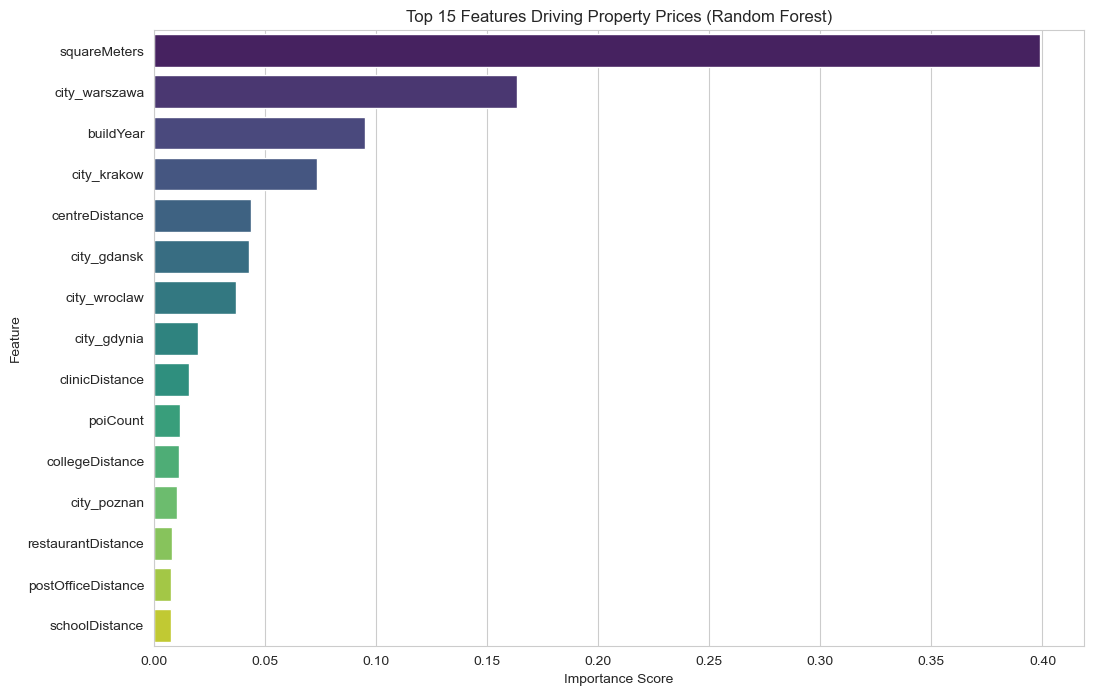

In [10]:
# Extract feature importances
importances = rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display Top 10 Features
print("Top 10 Most Important Features:")
display(feature_importance_df.head(10))

# Plot Top 15 Features
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Features Driving Property Prices (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()